In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import numpy as np

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import datasets

In [4]:
X_digits, y_digits = datasets.load_digits(return_X_y=True)

In [5]:
import codeflare.pipelines.Datamodel as dm
import codeflare.pipelines.Runtime as rt

from sklearn.model_selection import KFold

In [6]:
import ray
ray.shutdown()

ray.init()

2021-06-09 17:11:12,675	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.37',
 'raylet_ip_address': '192.168.1.37',
 'redis_address': '192.168.1.37:6379',
 'object_store_address': '/tmp/ray/session_2021-06-09_17-11-11_289352_82102/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-09_17-11-11_289352_82102/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-09_17-11-11_289352_82102',
 'metrics_export_port': 59484,
 'node_id': '69baeb54516bd687adc2c1ebadb922fcf1d7d68f4ae9f1289bb9f879'}

In [7]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipeline = dm.Pipeline()
node_pca = dm.EstimatorNode('pca', pca)
node_logistic = dm.EstimatorNode('logistic', logistic)

pipeline.add_edge(node_pca, node_logistic)

# input to pipeline
pipeline_input = dm.PipelineInput()
pipeline_input.add_xy_arg(node_pca, dm.Xy(X_digits, y_digits))


In [9]:
import codeflare.pipelines.utils as cf_utils

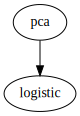

In [16]:
non_param_graph = cf_utils.pipeline_to_graph(pipeline)
non_param_graph

In [12]:
param_grid = {
        'pca__n_components': [5, 15, 30, 45, 64],
        'logistic__C': np.logspace(-4, 4, 4),
    }

pipeline_param = dm.PipelineParam.from_param_grid(param_grid)

In [13]:
parameterized_pipeline = pipeline.get_parameterized_pipeline(pipeline_param=pipeline_param)

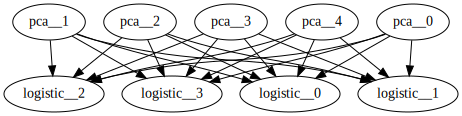

In [15]:
param_graph = cf_utils.pipeline_to_graph(parameterized_pipeline)
param_graph

In [17]:
k = 5
kf = KFold(k)

In [18]:
%%time
result = rt.grid_search_cv(kf, pipeline, pipeline_input, pipeline_param)

CPU times: user 1.5 s, sys: 903 ms, total: 2.41 s
Wall time: 9.33 s


In [19]:
import statistics

# pick the best mean'
best_pipeline = None
best_mean_scores = 0.0

for cv_pipeline, scores in result.items():
    mean = statistics.mean(scores)
    if mean > 0.92:
        print(mean)
        print(str(cv_pipeline))
        
    if mean > best_mean_scores:
        best_pipeline = cv_pipeline
        best_mean_scores = mean

0.9226679046734757
pca__3{'copy': True, 'iterated_power': 'auto', 'n_components': 45, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}=
logistic__1{'C': 0.046415888336127774, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.1, 'verbose': 0, 'warm_start': False}=pca__3{'copy': True, 'iterated_power': 'auto', 'n_components': 45, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False} 

0.9260058805323429
pca__4{'copy': True, 'iterated_power': 'auto', 'n_components': 64, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}=
logistic__1{'C': 0.046415888336127774, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': No

In [20]:
str(best_pipeline)

"pca__4{'copy': True, 'iterated_power': 'auto', 'n_components': 64, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}=\r\nlogistic__1{'C': 0.046415888336127774, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.1, 'verbose': 0, 'warm_start': False}=pca__4{'copy': True, 'iterated_power': 'auto', 'n_components': 64, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False} \r\n"

In [21]:
best_mean_scores

0.9260058805323429

In [22]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=1)

In [23]:
%%time
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}
CPU times: user 1min 40s, sys: 39.5 s, total: 2min 19s
Wall time: 20.4 s
